In [1]:
%matplotlib inline
from numpySOM import SOM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix

In [2]:
cpu_data = pd.read_csv('cassandra_data/cpu_active.csv', index_col=0)
memory_data = pd.read_csv('cassandra_data/memory_used.csv', index_col=0)
memory_data = memory_data/(1024*1024*1024) #remove this line once data you get is in GBs

In [3]:
cpu_data.head()

,cpu_node1,cpu_node2,cpu_node3
2019-04-16 14:18:40,0.225507,0.125408,NaN
2019-04-16 14:18:50,0.150301,0.150489,0.050138
2019-04-16 14:19:00,0.075207,0.050150,0.175483
2019-04-16 14:19:10,0.250501,0.100301,0.075245
2019-04-16 14:19:20,0.150301,0.025082,0.225338


In [4]:
memory_data.head()

,mem_used_node1,mem_used_node2,mem_used_node3
2019-04-16 14:18:30,4.362514,NaN,NaN
2019-04-16 14:18:40,4.362514,4.363770,NaN
2019-04-16 14:18:50,4.362617,4.363754,4.354584
2019-04-16 14:19:00,4.363064,4.364319,4.355049
2019-04-16 14:19:10,4.363052,4.364429,4.355160


In [9]:
dataset = pd.concat([cpu_data, memory_data], axis=1)

In [10]:
dataset.head()

,cpu_node1,cpu_node2,cpu_node3,mem_used_node1,mem_used_node2,mem_used_node3
2019-04-16 14:18:30,NaN,NaN,NaN,4.362514,NaN,NaN
2019-04-16 14:18:40,0.225507,0.125408,NaN,4.362514,4.363770,NaN
2019-04-16 14:18:50,0.150301,0.150489,0.050138,4.362617,4.363754,4.354584
2019-04-16 14:19:00,0.075207,0.050150,0.175483,4.363064,4.364319,4.355049
2019-04-16 14:19:10,0.250501,0.100301,0.075245,4.363052,4.364429,4.355160


In [15]:
dataset.fillna(method='bfill',  inplace=True)

In [17]:
X = dataset.values

In [18]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

In [20]:
len(X)

1231

In [21]:
import math
5*math.sqrt(1231)

175.42804792848835

In [22]:
math.sqrt(175)

13.228756555322953

In [23]:
x_dim, y_dim = 13, 13
som = SOM(M=x_dim, N=y_dim, noof_features=6, radius=1, learning_rate=0.5)

In [24]:
som.randomly_initialise_weights(X)
som.train_random(X, total_iterations=100)

In [25]:
MID_map = som.get_MID_map()

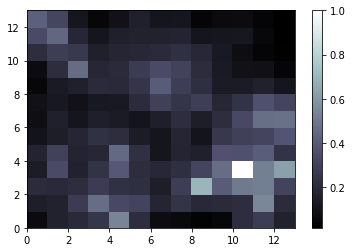

In [27]:
from pylab import bone, pcolor, colorbar, plot, show, figure
bone()
pcolor(MID_map.T)
colorbar()

In [31]:
mapping = som.bmu_to_data_points(X)

In [33]:
sc.inverse_transform(mapping[(11, 4)])

array([[0.0751503 , 0.07520682, 0.1002004 , 4.41586685, 4.4170723 ,
        4.40376282],
       [0.10015023, 0.02506894, 0.07520682, 4.41596985, 4.41706467,
        4.40374374],
       [0.15037594, 0.02506894, 0.15037594, 4.41594315, 4.41703415,
        4.40374374],
       [0.07516913, 0.07518797, 0.02507523, 4.41594315, 4.41701889,
        4.40383148],
       [0.02507523, 0.10027576, 0.07516913, 4.41592026, 4.41700745,
        4.40382385],
       [0.02506894, 0.07520682, 0.05012531, 4.41614151, 4.41711426,
        4.40381622],
       [0.0501002 , 0.02507523, 0.02508151, 4.41613388, 4.41710663,
        4.40380859],
       [0.07513148, 0.10032606, 0.07516913, 4.41630173, 4.41738129,
        4.40384674],
       [0.15037594, 0.        , 0.15033826, 4.41639328, 4.4174881 ,
        4.40383911],
       [0.05011275, 0.05012531, 0.1002004 , 4.41661453, 4.41746902,
        4.40393448],
       [0.07518797, 0.05016303, 0.1002004 , 4.41659164, 4.4174614 ,
        4.40391922],
       [0.05011275, 0

In [34]:
import pickle
def save(obj, filename):
    with open(filename, 'wb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)


def load(filename):
    with open(filename, 'rb') as input:
        return pickle.load(input)

In [35]:
save(som, 'cassandra_som.pkl')

In [51]:
save(sc, 'cassandra_sc.pkl')

In [67]:
import time, calendar
from datetime import datetime, timedelta
import requests
def get_data_sliding_window(window_size=600):
    current_time = datetime.now()
    start = current_time - timedelta(seconds=window_size)
    start_timestamp = time.mktime(start.timetuple())
    end_timestamp = time.mktime(current_time.timetuple())
    mem_used_query_params = {
        'query': "collectd_memory{memory='used'}",
        'start': start_timestamp,
        'end': end_timestamp,
        'step': "10"
    }
    
    cpu_query_params = {
        'query': "collectd_cpu_percent",
        'start': start_timestamp,
        'end': end_timestamp,
        'step': "10"
    }
    mem_used_response = requests.get('http://localhost:8080/api/v1/query_range', params=mem_used_query_params)
    cpu_response = requests.get('http://localhost:8080/api/v1/query_range', params=cpu_query_params)
    
    mem_used_results = mem_used_response.json()
    cpu_results = cpu_response.json()
    return {
        'cpu': cpu_results,
        'mem_used': mem_used_results
    }

In [68]:
data = get_data_sliding_window()

In [71]:
memory_data = data['mem_used']

In [72]:
memory_data

{'status': 'success',
 'data': {'resultType': 'matrix',
  'result': [{'metric': {'__name__': 'collectd_memory',
     'exported_instance': 'Node1',
     'instance': '172.31.94.73:9103',
     'job': 'node',
     'memory': 'used'},
    'values': [[1555592632, '4792471552'],
     [1555592642, '4792459264'],
     [1555592652, '4792459264'],
     [1555592662, '4792459264'],
     [1555592672, '4792459264'],
     [1555592682, '4792451072'],
     [1555592692, '4792451072'],
     [1555592702, '4792553472'],
     [1555592712, '4792528896'],
     [1555592722, '4792528896'],
     [1555592732, '4792528896'],
     [1555592742, '4792528896'],
     [1555592752, '4792201216'],
     [1555592762, '4792225792'],
     [1555592772, '4791590912'],
     [1555592782, '4791574528'],
     [1555592792, '4791566336'],
     [1555592802, '4791566336'],
     [1555592812, '4791558144'],
     [1555592822, '4791558144'],
     [1555592832, '4791558144'],
     [1555592842, '4791554048'],
     [1555592852, '4791549952'],
  

In [73]:
cpu_data = data['cpu']

In [74]:
cpu_data

{'status': 'success',
 'data': {'resultType': 'matrix',
  'result': [{'metric': {'__name__': 'collectd_cpu_percent',
     'cpu': 'active',
     'exported_instance': 'Node1',
     'instance': '172.31.94.73:9103',
     'job': 'node'},
    'values': [[1555592632, '0.175175175175175'],
     [1555592642, '0.0250438266967193'],
     [1555592652, '0.0501002004008016'],
     [1555592662, '0.0750750750750751'],
     [1555592672, '0.150262960180316'],
     [1555592682, '0.0501002004008016'],
     [1555592692, '0.0750938673341677'],
     [1555592702, '0.0751126690035053'],
     [1555592712, '0.0501127536958156'],
     [1555592722, '0.0500751126690035'],
     [1555592732, '0.0250438266967193'],
     [1555592742, '0.150075037518759'],
     [1555592752, '0.150262960180316'],
     [1555592762, '0.0751314800901578'],
     [1555592772, '0.0750938673341677'],
     [1555592782, '0.1001001001001'],
     [1555592792, '0.0751503006012024'],
     [1555592802, '0.100125156445557'],
     [1555592812, '0.075093

In [75]:
def get_df_from_json(json_data, metric="cpu"):
    metrics = json_data.get('data', {}).get('result', [])
    node1, node2, node3 = metrics[0], metrics[1], metrics[2]
    node1_values = node1['values']
    node1_timestamp = [datetime.fromtimestamp(val[0]) for val in node1_values]
    node1_val = [float(val[1]) for val in node1_values]

    node2_values = node2['values']
    node2_timestamp = [datetime.fromtimestamp(val[0]) for val in node2_values]
    node2_val = [float(val[1]) for val in node2_values]

    node3_values = node3['values']
    node3_timestamp = [datetime.fromtimestamp(val[0]) for val in node3_values]
    node3_val = [float(val[1]) for val in node3_values]
    
    ser1 = pd.Series(node1_val, index=node1_timestamp, name=metric+"_node1")
    ser2 = pd.Series(node2_val, index=node2_timestamp, name=metric+"_node2")
    ser3 = pd.Series(node3_val, index=node3_timestamp, name=metric+"_node3")
    
    df = pd.concat([ser1, ser2, ser3], axis=1)
    return df

In [76]:
test_cpu_dataframe = get_df_from_json(cpu_data)

In [77]:
test_mem_used_dataframe = get_df_from_json(memory_data, metric="mem_used")

In [78]:
test_mem_used_dataframe = test_mem_used_dataframe/(1024*1024*1024)

In [79]:
test_mem_used_dataframe.head()

,mem_used_node1,mem_used_node2,mem_used_node3
2019-04-18 09:03:52,4.463337,4.478874,4.477467
2019-04-18 09:04:02,4.463326,4.478859,4.477459
2019-04-18 09:04:12,4.463326,4.478855,4.477573
2019-04-18 09:04:22,4.463326,4.478848,4.477566
2019-04-18 09:04:32,4.463326,4.478958,4.477566


In [80]:
test_cpu_dataframe.head()

,cpu_node1,cpu_node2,cpu_node3
2019-04-18 09:03:52,0.175175,0.000000,0.075169
2019-04-18 09:04:02,0.025044,0.050100,0.050113
2019-04-18 09:04:12,0.050100,0.050113,0.100150
2019-04-18 09:04:22,0.075075,0.025038,0.075169
2019-04-18 09:04:32,0.150263,0.025056,0.075169


In [81]:
test_dataset = pd.concat([test_cpu_dataframe, test_mem_used_dataframe], axis=1)

In [82]:
test_dataset.head()

,cpu_node1,cpu_node2,cpu_node3,mem_used_node1,mem_used_node2,mem_used_node3
2019-04-18 09:03:52,0.175175,0.000000,0.075169,4.463337,4.478874,4.477467
2019-04-18 09:04:02,0.025044,0.050100,0.050113,4.463326,4.478859,4.477459
2019-04-18 09:04:12,0.050100,0.050113,0.100150,4.463326,4.478855,4.477573
2019-04-18 09:04:22,0.075075,0.025038,0.075169,4.463326,4.478848,4.477566
2019-04-18 09:04:32,0.150263,0.025056,0.075169,4.463326,4.478958,4.477566


In [86]:
clf_path = 'cassandra_som.pkl'
with open(clf_path, 'rb') as f:
    som = pickle.load(f)

scaler_path = 'cassandra_sc.pkl'
with open(scaler_path, 'rb') as f:
    sc = pickle.load(f)


In [87]:
MID_map = som.get_MID_map()

all_mids = []
x_dim, y_dim = len(som.neigx), len(som.neigy)
for i in range(x_dim):
    for j in range(y_dim):
        all_mids.append(MID_map[i][j])

In [89]:
p = np.percentile(all_mids, 85)

In [90]:
p

0.344334636773298

In [91]:
X_test = test_dataset.values

In [92]:
X_test = sc.transform(X_test)

In [99]:
X_test[1]

array([0.00311136, 0.01535764, 0.00614151, 1.01775399, 1.18056262,
       1.28638179])

In [102]:
N = len(X_test)
mid_test = []
for i in range(N):
    bmu = som.best_matching_unit(X_test[i])
    mid = MID_map[bmu]
    mid_test.append(mid)

In [103]:
for mid in mid_test:
    if mid>p:
        print('send slack alert')
        